In [48]:
from qr import conquer
import numpy as np
import numpy.random as rgt
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
n, p = 2000, 20
tau, t_df = 0.7, 2

#beta = rgt.multivariate_normal(np.zeros(p), np.identity(p))
#beta /= beta.dot(beta)**0.5

rgt.seed(0)
beta = np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1)
itcp = 1

### Gaussian design

In [12]:
X = rgt.normal(0, 1, size=(n,p))
err = rgt.standard_t(t_df, n) - t.ppf(tau, t_df)
Y = itcp + X.dot(beta) + err

sqr = conquer(X, Y)
qr_beta, qr_seq, qr_fit = sqr.rq(tau=tau, beta0=np.zeros(p+1), res=Y)
sqr_beta, sqr_seq, sqr_fit = sqr.gd(tau=tau, beta0=np.zeros(p+1), res=Y)

qr_sse_seq = np.sum((qr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
sqr_sse_seq = np.sum((sqr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5

In [13]:
print('qr-sse:', sum((qr_beta[1:] - beta)**2),
      '\nqr-niter', qr_fit[1],
     '\nsqr-sse:', sum((sqr_beta[1:] - beta)**2),
     '\nsqr-niter', sqr_fit[2])

qr-sse: 0.04673917861058839 
qr-niter 5000 
sqr-sse: 0.03913743816978927 
sqr-niter 66


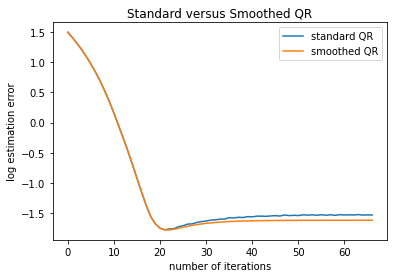

In [14]:
niter = np.array(range(0,sqr_fit[2]+1))

plt.plot(niter, np.log(qr_sse_seq[niter]), label='standard QR')
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='smoothed QR')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('Standard versus Smoothed QR')
plt.legend()

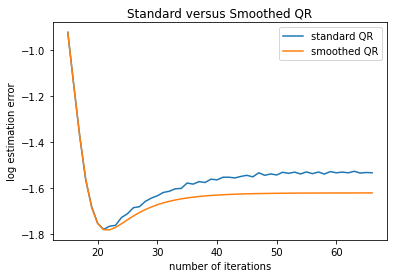

In [17]:
niter = np.array(range(15,sqr_fit[2]+1))

plt.plot(niter, np.log(qr_sse_seq[niter]), label='standard QR')
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='smoothed QR')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('Standard versus Smoothed QR')
plt.legend()

In [18]:
mu = 0.5
B = (p + np.log(n))**0.5
T = 4*np.ceil(np.log(n))
sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

priv_beta, priv_seq, priv_fit = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=1*sigma, max_iter=T)
priv_sse_seq = np.sum( (priv_seq[1:,:] - beta[:,None])**2, axis=0)**0.5

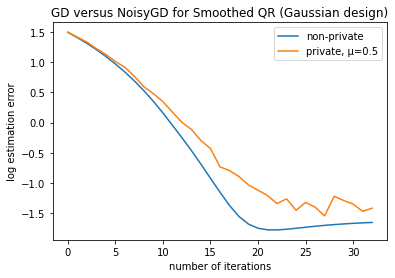

In [24]:
niter = np.array(range(0, min(sqr_fit[2]+1, int(T)+1)))
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='non-private')
plt.plot(niter, np.log(priv_sse_seq[niter]), label='private, \u03BC=0.5')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('GD versus NoisyGD for Smoothed QR (Gaussian design)')
plt.legend()

# Simulations (Gaussian design)

### Part 1: fix $(n, p)$, compare the iteration path.

In [3]:
M = 500
T = int(4*np.ceil(np.log(n)))
qr_sse_seq = np.zeros([T+1, M])
sqr_sse_seq = np.zeros([T+1, M])
priv_sse_seq0 = np.zeros([T+1, M])
priv_sse_seq1 = np.zeros([T+1, M])

# privacy parameter
mu = np.array([0.5, 0.8])
# truncation parameter 
B = (p + np.log(n))**0.5
# noisy scale
sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

for m in range(M):
    X = rgt.normal(0, 1, size=(n,p))
    Y = itcp + X.dot(beta) + rgt.standard_t(t_df, n) - t.ppf(tau, t_df)
    
    sqr = conquer(X, Y)
    # non-private QR and SQR
    qr_beta, qr_seq, qr_fit = sqr.rq(tau=tau, beta0=np.zeros(p+1), res=Y, max_iter=T)
    sqr_beta, sqr_seq, sqr_fit = sqr.gd(tau=tau, beta0=np.zeros(p+1), res=Y, max_iter=T)
    
    # private SQR
    priv_beta0, priv_seq0, priv_fit0 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=sigma[0], max_iter=T)
    priv_beta1, priv_seq1, priv_fit1 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=sigma[1], max_iter=T)
    
    qr_sse_seq[:,m] = np.sum((qr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
    sqr_sse_seq[:,m] = np.sum((sqr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
    priv_sse_seq0[:,m] = np.sum((priv_seq0[1:,:] - beta[:,None])**2, axis=0)**0.5
    priv_sse_seq1[:,m] = np.sum((priv_seq1[1:,:] - beta[:,None])**2, axis=0)**0.5

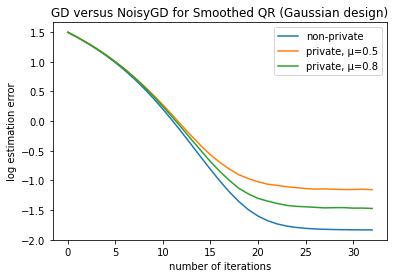

In [4]:
niter = np.array(range(0, int(T)+1))
plt.plot(niter, np.mean(np.log(sqr_sse_seq[niter,:]), axis=1), label='non-private')
plt.plot(niter, np.mean(np.log(priv_sse_seq0[niter,:]), axis=1), label='private, \u03BC=0.5')
plt.plot(niter, np.mean(np.log(priv_sse_seq1[niter,:]), axis=1), label='private, \u03BC=0.8')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('GD versus NoisyGD for Smoothed QR (Gaussian design)')
plt.legend()

### Part 2: fixed $p$ and growing $n$.

In [80]:
M = 200
n = np.array(range(2000, 20000+500, 500))

sqr_sse_seq = np.zeros([len(n), M])
priv_sse_seq0 = np.zeros([len(n), M])
priv_sse_seq1 = np.zeros([len(n), M])

mu = np.array([0.5, 0.8])

for m in range(M):
    
    X = rgt.normal(0, 1, size=(n[-1],p))
    Y = itcp + X.dot(beta) + rgt.standard_t(t_df, n[-1]) - t.ppf(tau, t_df)
    
    for k in range(len(n)):
        sqr = conquer(X[:n[k],], Y[:n[k]])
        sqr_beta, sqr_fit = sqr.fit(tau=tau)
        
        B = (p + np.log(n[k]))**0.5
        T = int(4*np.ceil(np.log(n[k])))
        sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

        # private SQR
        priv_beta0, priv_seq0, priv_fit0 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y[:n[k]], B=B, sigma=sigma[0], max_iter=T)
        priv_beta1, priv_seq1, priv_fit1 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y[:n[k]], B=B, sigma=sigma[1], max_iter=T)
    
        sqr_sse_seq[k,m] = np.sum((sqr_beta[1:] - beta)**2)**0.5
        priv_sse_seq0[k,m] = np.sum((priv_beta0[1:] - beta)**2)**0.5
        priv_sse_seq1[k,m] = np.sum((priv_beta1[1:] - beta)**2)**0.5
    if m > 0 and m%10 == 0: print(m,'repetitions')

10 repetitions
20 repetitions
30 repetitions
40 repetitions
50 repetitions
60 repetitions
70 repetitions
80 repetitions
90 repetitions
100 repetitions
110 repetitions
120 repetitions
130 repetitions
140 repetitions
150 repetitions
160 repetitions
170 repetitions
180 repetitions
190 repetitions


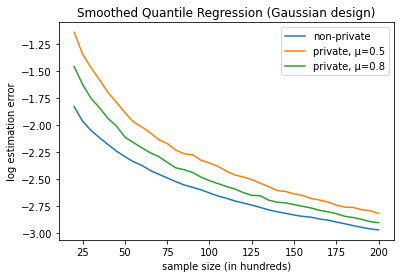

In [81]:
plt.plot(n/100, np.mean(np.log(sqr_sse_seq), axis=1), label='non-private')
plt.plot(n/100, np.mean(np.log(priv_sse_seq0), axis=1), label='private, \u03BC=0.5')
plt.plot(n/100, np.mean(np.log(priv_sse_seq1), axis=1), label='private, \u03BC=0.8')
plt.xlabel('sample size (in hundreds)')
plt.ylabel('log estimation error')
plt.title('Smoothed Quantile Regression (Gaussian design)')
plt.legend()

# Simulations (Uniform design)

In [3]:
X = rgt.uniform(-1, 1, size=(n,p))
err = rgt.standard_t(t_df, n) - t.ppf(tau, t_df)
Y = itcp + X.dot(beta) + err

sqr = conquer(X, Y)
qr_beta, qr_seq, qr_fit = sqr.rq(tau=tau, beta0=np.zeros(p+1), res=Y)
sqr_beta, sqr_seq, sqr_fit = sqr.gd(tau=tau, beta0=np.zeros(p+1), res=Y)

qr_sse_seq = np.sum((qr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
sqr_sse_seq = np.sum((sqr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5

In [5]:
print('qr-sse:', sum((qr_beta[1:] - beta)**2),
      '\nqr-niter', qr_fit[1],
     '\nsqr-sse:', sum((sqr_beta[1:] - beta)**2),
     '\nsqr-niter', sqr_fit[2])

qr-sse: 0.076449655802145 
qr-niter 5000 
sqr-sse: 0.06950601080576968 
sqr-niter 52


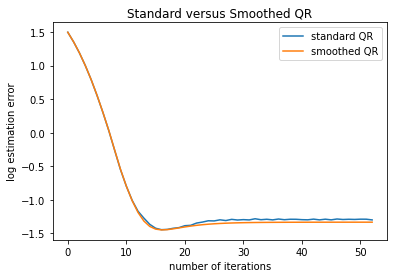

In [6]:
niter = np.array(range(0,sqr_fit[2]+1))

plt.plot(niter, np.log(qr_sse_seq[niter]), label='standard QR')
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='smoothed QR')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('Standard versus Smoothed QR')
plt.legend()

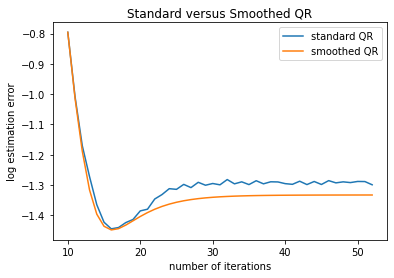

In [9]:
niter = np.array(range(10,sqr_fit[2]+1))

plt.plot(niter, np.log(qr_sse_seq[niter]), label='standard QR')
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='smoothed QR')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('Standard versus Smoothed QR')
plt.legend()

In [22]:
mu = 0.5
B = p**0.5
#B = np.max(np.array([X[i,:].dot(X[i,:]) for i in range(n)]))**0.5
T = 4*np.ceil(np.log(n))
sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

priv_beta, priv_seq, priv_fit = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=1*sigma, max_iter=T)
priv_sse_seq = np.sum( (priv_seq[1:,:] - beta[:,None])**2, axis=0)**0.5

print(np.sum((priv_beta[1:] - beta)**2)**0.5, priv_fit[1])

0.24157439082917898 0.08261653226876783


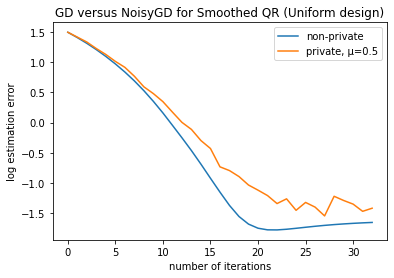

In [25]:
niter = np.array(range(0, min(sqr_fit[2]+1, int(T)+1)))
plt.plot(niter, np.log(sqr_sse_seq[niter]), label='non-private')
plt.plot(niter, np.log(priv_sse_seq[niter]), label='private, \u03BC=0.5')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('GD versus NoisyGD for Smoothed QR (Uniform design)')
plt.legend()

### Part 1: fix $(n, p)$, compare the iteration path.

In [18]:
M = 200
T = int(4*np.ceil(np.log(n)))
qr_sse_seq = np.zeros([T+1, M])
sqr_sse_seq = np.zeros([T+1, M])
priv_sse_seq0 = np.zeros([T+1, M])
priv_sse_seq1 = np.zeros([T+1, M])

# privacy parameter
mu = np.array([0.5, 0.8])
# truncation parameter 
B = p**0.5
# noisy scale
sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

for m in range(M):
    X = rgt.uniform(-1, 1, size=(n,p))
    Y = itcp + X.dot(beta) + rgt.standard_t(t_df, n) - t.ppf(tau, t_df)
    
    sqr = conquer(X, Y)
    # non-private QR and SQR
    qr_beta, qr_seq, qr_fit = sqr.rq(tau=tau, beta0=np.zeros(p+1), res=Y, max_iter=T)
    sqr_beta, sqr_seq, sqr_fit = sqr.gd(tau=tau, beta0=np.zeros(p+1), res=Y, max_iter=T)
    
    # private SQR
    priv_beta0, priv_seq0, priv_fit0 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=sigma[0], max_iter=T)
    priv_beta1, priv_seq1, priv_fit1 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y, B=B, sigma=sigma[1], max_iter=T)
    
    qr_sse_seq[:,m] = np.sum((qr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
    sqr_sse_seq[:,m] = np.sum((sqr_seq[1:,:] - beta[:,None])**2, axis=0)**0.5
    priv_sse_seq0[:,m] = np.sum((priv_seq0[1:,:] - beta[:,None])**2, axis=0)**0.5
    priv_sse_seq1[:,m] = np.sum((priv_seq1[1:,:] - beta[:,None])**2, axis=0)**0.5


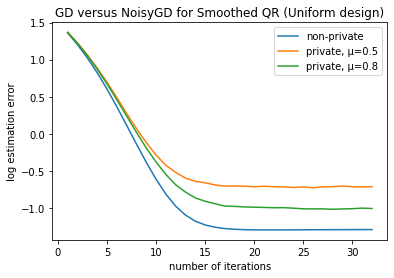

In [23]:
niter = np.array(range(1, int(T)+1))
plt.plot(niter, np.mean(np.log(sqr_sse_seq[niter,:]), axis=1), label='non-private')
plt.plot(niter, np.mean(np.log(priv_sse_seq0[niter,:]), axis=1), label='private, \u03BC=0.5')
plt.plot(niter, np.mean(np.log(priv_sse_seq1[niter,:]), axis=1), label='private, \u03BC=0.8')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('GD versus NoisyGD for Smoothed QR (Uniform design)')
plt.legend()

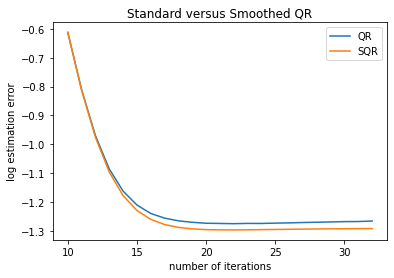

In [20]:
niter = np.array(range(10, int(T)+1))
plt.plot(niter, np.mean(np.log(qr_sse_seq[niter,:]), axis=1), label='QR')
plt.plot(niter, np.mean(np.log(sqr_sse_seq[niter,:]), axis=1), label='SQR')
plt.xlabel('number of iterations')
plt.ylabel('log estimation error')
plt.title('Standard versus Smoothed QR')
plt.legend()

### Part 2: fix $p$ and let $n$ increase.

In [45]:
M = 200
n = np.array(range(2000, 20000+500, 500))

sqr_sse_seq = np.zeros([len(n), M])
priv_sse_seq0 = np.zeros([len(n), M])
priv_sse_seq1 = np.zeros([len(n), M])

mu = np.array([0.5, 0.8])
B = p**0.5

for m in range(M):
    
    X = rgt.uniform(-1, 1, size=(n[-1],p))
    Y = itcp + X.dot(beta) + rgt.standard_t(t_df, n[-1]) - t.ppf(tau, t_df)
    
    for k in range(len(n)):
        sqr = conquer(X[:n[k],], Y[:n[k]])
        sqr_beta, sqr_fit = sqr.fit(tau=tau)
        
        T = int(4*np.ceil(np.log(n[k])))
        sigma = 2*max(tau, 1-tau)*B*(T**0.5)/mu

        # private SQR
        priv_beta0, priv_seq0, priv_fit0 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y[:n[k]], B=B, sigma=sigma[0], max_iter=T)
        priv_beta1, priv_seq1, priv_fit1 = sqr.noisygd(tau=tau, beta0=np.zeros(p+1), res=Y[:n[k]], B=B, sigma=sigma[1], max_iter=T)
    
        sqr_sse_seq[k,m] = np.sum((sqr_beta[1:] - beta)**2)**0.5
        priv_sse_seq0[k,m] = np.sum((priv_beta0[1:] - beta)**2)**0.5
        priv_sse_seq1[k,m] = np.sum((priv_beta1[1:] - beta)**2)**0.5
    if m > 0 and m%10 == 0: print(m,'repetitions')

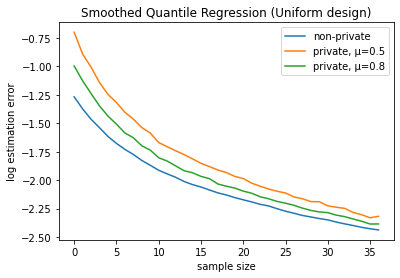

In [54]:
plt.plot(n/100, np.mean(np.log(sqr_sse_seq), axis=1), label='non-private')
plt.plot(n/100, np.mean(np.log(priv_sse_seq0), axis=1), label='private, \u03BC=0.5')
plt.plot(n/100, np.mean(np.log(priv_sse_seq1), axis=1), label='private, \u03BC=0.8')
plt.xlabel('sample size (in hundreds)')
plt.ylabel('log estimation error')
plt.title('Smoothed Quantile Regression (Uniform design)')
plt.legend()